<!-- The loan dataset is a collection of information about people who applied for loans in the past,
along with whether their loan was approved or rejected. It contains details about each applicant,
such as their gender, marital status, number of dependents, education level, income,
the loan amount they requested, and how long they want to repay it. It also includes their credit 
history, which shows if they have previously paid loans on time. The final column,
 called Loan_Status, tells whether the bank approved the loan or not. By studying these patterns,
 a machine learning model can learn how banks make decisions and can predict whether a new applicant’s
 loan should be approved.  -->

In [41]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.base import BaseEstimator, TransformerMixin

In [42]:
class OutlierToMedianTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, feature_names):
        self.feature_names = feature_names
        self.bounds_ = {}

    def fit(self, X, y=None):
        X_df = pd.DataFrame(X, columns=self.feature_names)
        for col in self.feature_names:
            Q1 = X_df[col].quantile(0.25)
            Q3 = X_df[col].quantile(0.75)
            IQR = Q3 - Q1
            self.bounds_[col] = (Q1 - 1.5 * IQR, Q3 + 1.5 * IQR)
        return self

    def transform(self, X):
        X_df = pd.DataFrame(X, columns=self.feature_names)
        for col, (lower, upper) in self.bounds_.items():
            X_df[col] = np.where((X_df[col] < lower) | (X_df[col] > upper), np.nan, X_df[col])
        return X_df.values

def clean_col_name(col):
    col = col.strip().lower()
    col = re.sub(r'[^\w]+', '_', col)
    col = col.strip('_')
    return col

In [43]:
df = pd.read_csv(r"C:\Users\Noman Traders\Downloads\Housing.csv")
df.columns = [clean_col_name(col) for col in df.columns]

In [44]:
df.columns

Index(['price', 'area', 'bedrooms', 'bathrooms', 'stories', 'mainroad',
       'guestroom', 'basement', 'hotwaterheating', 'airconditioning',
       'parking', 'prefarea', 'furnishingstatus'],
      dtype='object')

In [45]:
target_col = 'price'
df.rename(columns={target_col:'price_target'}, inplace=True)
target_col = 'price_target'

In [46]:
df.drop_duplicates(inplace=True)
df = df.dropna(subset=[target_col])

In [47]:
df.columns

Index(['price_target', 'area', 'bedrooms', 'bathrooms', 'stories', 'mainroad',
       'guestroom', 'basement', 'hotwaterheating', 'airconditioning',
       'parking', 'prefarea', 'furnishingstatus'],
      dtype='object')

In [48]:
X = df.drop(df[["price_target"]], axis=1)
Y = df[target_col]

In [49]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [50]:
numericals_cols = X_train.select_dtypes(include=np.number).columns.tolist()
categorical_cols = X_train.select_dtypes(include='object').columns.tolist()

In [51]:
skewness = X_train[numericals_cols].apply(lambda x: x.skew()).abs()
skew_threshold = 0.5

In [52]:
skewed_cols = skewness[skewness >= skew_threshold].index.tolist()
normal_cols = skewness[skewness < skew_threshold].index.tolist()

In [53]:
skewed_pipe = Pipeline(steps=[
    ('outliers', OutlierToMedianTransformer(feature_names=skewed_cols)),
    ('imputer', SimpleImputer(strategy='median')),
    ('power', PowerTransformer(method='yeo-johnson')),
    ('scale', StandardScaler())
])

In [54]:
if not normal_cols:
    normal_pipe = 'drop' 
else:
    normal_pipe = Pipeline(steps=[
        ('outlier', OutlierToMedianTransformer(feature_names=normal_cols)),
        ('imputer', SimpleImputer(strategy='mean')),
        ('scale', StandardScaler())
    ])

In [55]:
cat_pipe = Pipeline(steps=[
    ('imputeer', SimpleImputer(strategy="most_frequent")),
    ('ohe', OneHotEncoder(handle_unknown='ignore'))
])

In [56]:
preprocessor = ColumnTransformer(
    transformers=[
        ('skewed_proc', skewed_pipe, skewed_cols),
        ('normal_proc', normal_pipe, normal_cols),
        ('cat_proc', cat_pipe, categorical_cols)
    ],
    remainder='drop'
)

In [57]:
model_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])

In [58]:
model_pipeline.fit(X_train, Y_train)

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('skewed_proc', ...), ('normal_proc', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [59]:
y_pred = model_pipeline.predict(X_test)

In [60]:
mse = mean_squared_error(Y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(Y_test, y_pred)

In [68]:
print("Mean Square Error: ",mse)
print("Root Mean Square Error: ", rmse)
print(f"R2: {r2*100.:2f}")

Mean Square Error:  1918457775329.9946
Root Mean Square Error:  1385084.031865935
R2: 62.045086


In [62]:
first_skewed_col = skewed_cols[0]
first_skewed_index = preprocessor.transformers_[0][2].index(first_skewed_col)
X_train_transformed = model_pipeline['preprocessor'].transform(X_train)

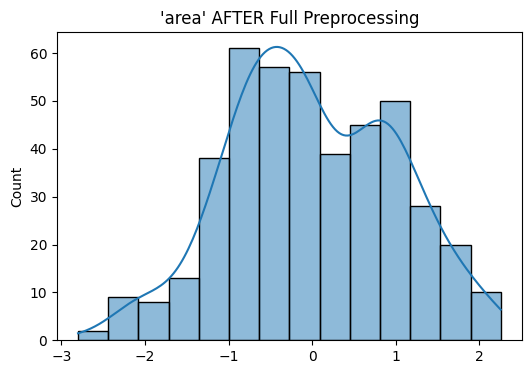

In [63]:
plt.figure(figsize=(6,4))
sns.histplot(X_train_transformed[:, first_skewed_index], kde=True)
plt.title(f"'{first_skewed_col}' AFTER Full Preprocessing")
plt.show()

In [64]:
from sklearn import set_config
set_config(display='diagram')
model_pipeline

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('skewed_proc', ...), ('normal_proc', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
